# Init

In [0]:
%matplotlib inline

import torch
import random
import numpy as np
import time
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets

In [3]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

0it [00:00, ?it/s]

 99%|█████████▉| 168534016/170498071 [00:14<00:00, 17452987.06it/s]

Files already downloaded and verified


In [0]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [0]:
X_train /= 255.
X_test /= 255.

In [0]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [0]:
def set_seed(seed = 51):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [0]:
def train(net, X_train, y_train, X_test, y_test, epoch_N = 30,
          batch_size = 100, wd=1e-4):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=wd)
    
    
    t = time.time()
    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(epoch_N):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
              
            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            # del X_batch
            # del y_batch

        net.eval()
        with torch.no_grad():
          test_preds = net.forward(X_test)
          loss_value = loss(test_preds, y_test).item()
          test_loss_history.append(loss_value)

          accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
          test_accuracy_history.append(accuracy)
        
          print('Epoch: {} Time: {} Accuracy: {}'\
                .format(epoch, time.strftime("%H:%M:%S", time.gmtime(time.time() - t)), accuracy))

    del net    
    return test_accuracy_history, test_loss_history

In [0]:
accuracies = {}
loss = {} 

# Models

## CIFARNet

In [0]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        
        self.fc3   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        
        return x

## ResNet18

In [0]:
from torchvision.models import resnet18

## ResNet for CIFAR-10

In [0]:
from torch.nn.functional import avg_pool2d

In [0]:
class ResBlock(torch.nn.Module):
    def __init__(self, in_chanels, out_chanels, 
                 start_stride=1, **kwargs):
        super(ResBlock, self).__init__()
        
        self.dropout = kwargs.get('dropout', False)
        self.batch_norm = kwargs.get('batch_norm', True)
        self.dropout_p = kwargs.get('dropout_p', 0.5)
        self.in_chanels = in_chanels
        self.out_chanels = out_chanels 
        self.start_stride = start_stride
        
        self.conv1 = torch.nn.Conv2d(
            in_chanels, out_chanels, kernel_size=3,
            padding=1, stride=start_stride, bias=False
        )
        self.batch_norm1 = torch.nn.BatchNorm2d(out_chanels)
        self.dropout1 = torch.nn.Dropout2d(self.dropout_p)
        self.act1  = torch.nn.ReLU()
        
        self.conv2 = torch.nn.Conv2d(
            out_chanels, out_chanels, kernel_size=3,
            padding=1, bias=False
        )
        self.batch_norm2 = torch.nn.BatchNorm2d(out_chanels)
        self.dropout2 = torch.nn.Dropout2d(self.dropout_p)
        
        self.x_prepare = torch.nn.Sequential()
        if in_chanels != out_chanels or start_stride != 1:
          self.x_prepare = torch.nn.Sequential(
              torch.nn.Conv2d(in_chanels, out_chanels, kernel_size=1,
                              stride=start_stride, bias=False),
              torch.nn.BatchNorm2d(out_chanels)
          )
        self.act2 = torch.nn.ReLU()
        

    def forward(self, x):
      out = self.conv1(x)
      if self.batch_norm:
        out = self.batch_norm1(out)
      if self.dropout:
        out = self.dropout1(out)
      out = self.act1(out)
      
      out = self.conv2(out)
      if self.batch_norm:
        out = self.batch_norm2(out)
      if self.dropout:
        out = self.dropout2(out)
        
      out += self.x_prepare(x)
      out = self.act2(out)
      return out

In [0]:
class ResNet_CIFAR_10(torch.nn.Module):
  def __init__(self, n, **kwargs):
    super(ResNet_CIFAR_10, self).__init__()
    self.dropout = kwargs.get('dropout', False)
    self.dropout_p = kwargs.get('dropout_p', 0.5)
    self.batch_norm = kwargs.get('batch_norm', True)
    self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
    self.batch_norm1 = torch.nn.BatchNorm2d(16)
    self.dropout1 = torch.nn.Dropout2d(self.dropout_p)
        
    self.size_layer1 = self._create_size_layer(n, 16, 16, 
                                               start_stride=1,
                                               **kwargs)
    self.size_layer2 = self._create_size_layer(n, 16, 32, 
                                               start_stride=2,
                                               **kwargs)
    self.size_layer3 = self._create_size_layer(n, 32, 64, 
                                               start_stride=2,
                                               **kwargs)
    self.linear = torch.nn.Linear(64, 10)
    
  def _create_size_layer(self, n, in_chanels, out_chanels, start_stride=1,
                         **kwargs):
    blocks_list = []
    blocks_list.append(
          ResBlock(in_chanels, out_chanels, 
                   start_stride=start_stride,
                   **kwargs)
    )
    for i in range(n-1):
      blocks_list.append(
          ResBlock(out_chanels, out_chanels,
                   **kwargs)
      )
    return torch.nn.Sequential(*blocks_list)
    
  def forward(self, x):
      out = self.conv1(x)
      if self.batch_norm:
        out = self.batch_norm1(out)
      if self.dropout:
        out = self.dropout1(out)
      out = self.size_layer1(out)
      out = self.size_layer2(out)
      out = self.size_layer3(out)
      out = avg_pool2d(out, out.size()[3])
      out = out.view(out.size(0), -1)
      out = self.linear(out)
      return out

## ResNet20

In [0]:
def ResNet20(**kwargs):
  return ResNet_CIFAR_10(3, **kwargs)

## ResNet110

In [0]:
def ResNet110(**kwargs):
  return ResNet_CIFAR_10(18, **kwargs)

# Train

## CIFARNet

In [17]:
set_seed(seed = 42)
accuracies['cifar_net'], loss['cifar_net'] = train(CIFARNet(), X_train, y_train, X_test, y_test)
torch.cuda.empty_cache()

170500096it [00:29, 17452987.06it/s]                               

Epoch: 0 Time: 00:00:06 Accuracy: 0.6783999800682068
Epoch: 1 Time: 00:00:13 Accuracy: 0.70660001039505
Epoch: 2 Time: 00:00:19 Accuracy: 0.7222999930381775
Epoch: 3 Time: 00:00:25 Accuracy: 0.7263000011444092
Epoch: 4 Time: 00:00:32 Accuracy: 0.7231999635696411
Epoch: 5 Time: 00:00:38 Accuracy: 0.7214999794960022
Epoch: 6 Time: 00:00:44 Accuracy: 0.717799961566925
Epoch: 7 Time: 00:00:51 Accuracy: 0.7185999751091003
Epoch: 8 Time: 00:00:57 Accuracy: 0.7099999785423279
Epoch: 9 Time: 00:01:04 Accuracy: 0.7293999791145325
Epoch: 10 Time: 00:01:10 Accuracy: 0.7293999791145325
Epoch: 11 Time: 00:01:16 Accuracy: 0.7195000052452087
Epoch: 12 Time: 00:01:23 Accuracy: 0.7146999835968018
Epoch: 13 Time: 00:01:29 Accuracy: 0.713699996471405
Epoch: 14 Time: 00:01:36 Accuracy: 0.7105000019073486
Epoch: 15 Time: 00:01:42 Accuracy: 0.7210999727249146
Epoch: 16 Time: 00:01:48 Accuracy: 0.7240999937057495
Epoch: 17 Time: 00:01:55 Accuracy: 0.7263999581336975
Epoch: 18 Time: 00:02:01 Accuracy: 0.72279

## ResNet18

In [18]:
set_seed(seed = 42)
accuracies['resnet18'], loss['resnet18'] = train(resnet18(), X_train, y_train, X_test, y_test)
torch.cuda.empty_cache()                                                 

Epoch: 0 Time: 00:00:38 Accuracy: 0.5565999746322632
Epoch: 1 Time: 00:01:17 Accuracy: 0.6288999915122986
Epoch: 2 Time: 00:01:56 Accuracy: 0.652999997138977
Epoch: 3 Time: 00:02:35 Accuracy: 0.6298999786376953
Epoch: 4 Time: 00:03:13 Accuracy: 0.6812999844551086
Epoch: 5 Time: 00:03:52 Accuracy: 0.718999981880188
Epoch: 6 Time: 00:04:31 Accuracy: 0.7048999667167664
Epoch: 7 Time: 00:05:09 Accuracy: 0.7190999984741211
Epoch: 8 Time: 00:05:48 Accuracy: 0.7055999636650085
Epoch: 9 Time: 00:06:26 Accuracy: 0.7486000061035156
Epoch: 10 Time: 00:07:05 Accuracy: 0.7389000058174133
Epoch: 11 Time: 00:07:43 Accuracy: 0.7231000065803528
Epoch: 12 Time: 00:08:22 Accuracy: 0.7336999773979187
Epoch: 13 Time: 00:09:00 Accuracy: 0.7443000078201294
Epoch: 14 Time: 00:09:39 Accuracy: 0.7174999713897705
Epoch: 15 Time: 00:10:17 Accuracy: 0.7509999871253967
Epoch: 16 Time: 00:10:56 Accuracy: 0.72079998254776
Epoch: 17 Time: 00:11:34 Accuracy: 0.7520999908447266
Epoch: 18 Time: 00:12:13 Accuracy: 0.73899

## Basic ResNet20

In [19]:
set_seed(seed = 42)
accuracies['resnet20'], loss['resnet20'] = train(ResNet20(), X_train, y_train, X_test, y_test)  

Epoch: 0 Time: 00:00:33 Accuracy: 0.5618000030517578
Epoch: 1 Time: 00:01:07 Accuracy: 0.6067000031471252
Epoch: 2 Time: 00:01:41 Accuracy: 0.7044999599456787
Epoch: 3 Time: 00:02:15 Accuracy: 0.7116000056266785
Epoch: 4 Time: 00:02:49 Accuracy: 0.7339000105857849
Epoch: 5 Time: 00:03:23 Accuracy: 0.758899986743927
Epoch: 6 Time: 00:03:57 Accuracy: 0.7834999561309814
Epoch: 7 Time: 00:04:31 Accuracy: 0.7708999514579773
Epoch: 8 Time: 00:05:05 Accuracy: 0.7739999890327454
Epoch: 9 Time: 00:05:39 Accuracy: 0.7694999575614929
Epoch: 10 Time: 00:06:12 Accuracy: 0.7687000036239624
Epoch: 11 Time: 00:06:46 Accuracy: 0.7853999733924866
Epoch: 12 Time: 00:07:20 Accuracy: 0.7986999750137329
Epoch: 13 Time: 00:07:54 Accuracy: 0.7626000046730042
Epoch: 14 Time: 00:08:28 Accuracy: 0.7932999730110168
Epoch: 15 Time: 00:09:02 Accuracy: 0.8033999800682068
Epoch: 16 Time: 00:09:36 Accuracy: 0.793999969959259
Epoch: 17 Time: 00:10:10 Accuracy: 0.7919999957084656
Epoch: 18 Time: 00:10:44 Accuracy: 0.746

## ResNet20 with dropout

In [20]:
for dropout_p in [0.5, 0.4, 0.25, 0.1]:
  set_seed(seed = 42)
  name = 'resnet20_dropout_{}'.format(dropout_p)
  accuracies[name], loss[name] = train(
      ResNet20(dropout=True, dropout_p=dropout_p), 
      X_train, y_train, X_test, y_test
  )

Epoch: 0 Time: 00:00:35 Accuracy: 0.23600000143051147
Epoch: 1 Time: 00:01:10 Accuracy: 0.31779998540878296
Epoch: 2 Time: 00:01:45 Accuracy: 0.362199991941452
Epoch: 3 Time: 00:02:20 Accuracy: 0.3854999840259552
Epoch: 4 Time: 00:02:55 Accuracy: 0.4087999761104584
Epoch: 5 Time: 00:03:31 Accuracy: 0.43389999866485596
Epoch: 6 Time: 00:04:06 Accuracy: 0.43320000171661377
Epoch: 7 Time: 00:04:41 Accuracy: 0.45339998602867126
Epoch: 8 Time: 00:05:16 Accuracy: 0.4730999767780304
Epoch: 9 Time: 00:05:51 Accuracy: 0.4729999899864197
Epoch: 10 Time: 00:06:26 Accuracy: 0.5026999711990356
Epoch: 11 Time: 00:07:01 Accuracy: 0.5206999778747559
Epoch: 12 Time: 00:07:36 Accuracy: 0.5374000072479248
Epoch: 13 Time: 00:08:11 Accuracy: 0.5532000064849854
Epoch: 14 Time: 00:08:47 Accuracy: 0.568399965763092
Epoch: 15 Time: 00:09:22 Accuracy: 0.5805999636650085
Epoch: 16 Time: 00:09:57 Accuracy: 0.5924000144004822
Epoch: 17 Time: 00:10:32 Accuracy: 0.5942999720573425
Epoch: 18 Time: 00:11:07 Accuracy: 

## ResNet20 with l2

In [21]:
for wd in ['1e-2', '1e-3', '1e-4', '1e-5', '1e-6']:
  set_seed(seed = 42)
  name = 'resnet20_l2_{}'.format(wd)
  accuracies[name], loss[name] = train(
      ResNet20(), 
      X_train, y_train, X_test, y_test,
      wd=float(wd)
  )

Epoch: 0 Time: 00:00:33 Accuracy: 0.5152999758720398
Epoch: 1 Time: 00:01:07 Accuracy: 0.555400013923645
Epoch: 2 Time: 00:01:41 Accuracy: 0.6647999882698059
Epoch: 3 Time: 00:02:15 Accuracy: 0.6455000042915344
Epoch: 4 Time: 00:02:49 Accuracy: 0.6663999557495117
Epoch: 5 Time: 00:03:23 Accuracy: 0.6785999536514282
Epoch: 6 Time: 00:03:57 Accuracy: 0.64410001039505
Epoch: 7 Time: 00:04:31 Accuracy: 0.6406999826431274
Epoch: 8 Time: 00:05:04 Accuracy: 0.6750999689102173
Epoch: 9 Time: 00:05:38 Accuracy: 0.6703999638557434
Epoch: 10 Time: 00:06:12 Accuracy: 0.6897000074386597
Epoch: 11 Time: 00:06:46 Accuracy: 0.7177000045776367
Epoch: 12 Time: 00:07:20 Accuracy: 0.7335000038146973
Epoch: 13 Time: 00:07:54 Accuracy: 0.6852999925613403
Epoch: 14 Time: 00:08:27 Accuracy: 0.7293999791145325
Epoch: 15 Time: 00:09:01 Accuracy: 0.7209999561309814
Epoch: 16 Time: 00:09:35 Accuracy: 0.7411999702453613
Epoch: 17 Time: 00:10:09 Accuracy: 0.6444000005722046
Epoch: 18 Time: 00:10:42 Accuracy: 0.7584

## Basic ResNet110

In [22]:
set_seed(seed = 42)
accuracies['resnet110'], loss['resnet110'] = train(ResNet110(), X_train, y_train, X_test, y_test)  

Epoch: 0 Time: 00:03:22 Accuracy: 0.5067999958992004
Epoch: 1 Time: 00:06:44 Accuracy: 0.5950999855995178
Epoch: 2 Time: 00:10:06 Accuracy: 0.6620000004768372
Epoch: 3 Time: 00:13:28 Accuracy: 0.6687999963760376
Epoch: 4 Time: 00:16:50 Accuracy: 0.7235999703407288
Epoch: 5 Time: 00:20:13 Accuracy: 0.7536999583244324
Epoch: 6 Time: 00:23:35 Accuracy: 0.7644000053405762
Epoch: 7 Time: 00:26:57 Accuracy: 0.769599974155426
Epoch: 8 Time: 00:30:20 Accuracy: 0.8109999895095825
Epoch: 9 Time: 00:33:43 Accuracy: 0.7967000007629395
Epoch: 10 Time: 00:37:06 Accuracy: 0.8139999508857727
Epoch: 11 Time: 00:40:30 Accuracy: 0.8294000029563904
Epoch: 12 Time: 00:43:53 Accuracy: 0.7609999775886536
Epoch: 13 Time: 00:47:16 Accuracy: 0.8071999549865723
Epoch: 14 Time: 00:50:40 Accuracy: 0.8185999989509583
Epoch: 15 Time: 00:54:03 Accuracy: 0.8130999803543091
Epoch: 16 Time: 00:57:27 Accuracy: 0.8168999552726746
Epoch: 17 Time: 01:00:50 Accuracy: 0.8079999685287476
Epoch: 18 Time: 01:04:14 Accuracy: 0.82

## ResNet110 without batch norm

In [23]:
set_seed(seed = 42)
accuracies['resnet110_no_batch_norm'], loss['resnet110_no_batch_norm'] = \
   train(ResNet110(batch_norm=False), X_train, y_train, X_test, y_test)  

Epoch: 0 Time: 00:02:48 Accuracy: 0.4438000023365021
Epoch: 1 Time: 00:05:36 Accuracy: 0.49959999322891235
Epoch: 2 Time: 00:08:24 Accuracy: 0.579800009727478
Epoch: 3 Time: 00:11:12 Accuracy: 0.660099983215332
Epoch: 4 Time: 00:13:59 Accuracy: 0.677899956703186
Epoch: 5 Time: 00:16:47 Accuracy: 0.6746999621391296
Epoch: 6 Time: 00:19:35 Accuracy: 0.7192999720573425
Epoch: 7 Time: 00:22:23 Accuracy: 0.6764000058174133
Epoch: 8 Time: 00:25:11 Accuracy: 0.7489999532699585
Epoch: 9 Time: 00:27:58 Accuracy: 0.7534999847412109
Epoch: 10 Time: 00:30:46 Accuracy: 0.7430999875068665
Epoch: 11 Time: 00:33:33 Accuracy: 0.7609999775886536
Epoch: 12 Time: 00:36:21 Accuracy: 0.7669000029563904
Epoch: 13 Time: 00:39:09 Accuracy: 0.7684999704360962
Epoch: 14 Time: 00:41:56 Accuracy: 0.7242000102996826
Epoch: 15 Time: 00:44:44 Accuracy: 0.773099958896637
Epoch: 16 Time: 00:47:32 Accuracy: 0.7508999705314636
Epoch: 17 Time: 00:50:20 Accuracy: 0.7490999698638916
Epoch: 18 Time: 00:53:08 Accuracy: 0.7771

# Tasks

## 1. Сравнение ResNet18 и CIFARNet


### Accuracy

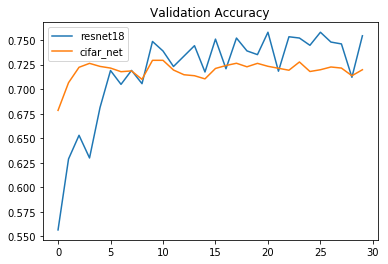

In [26]:
for net_name in ['resnet18', 'cifar_net']:
  plt.plot(accuracies[net_name], label=net_name)
plt.legend()
plt.title('Validation Accuracy');

### Loss

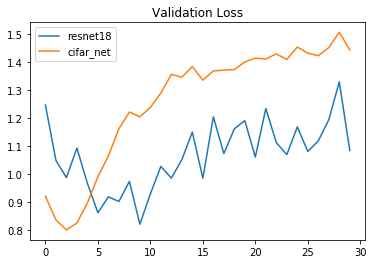

In [27]:
for net_name in ['resnet18', 'cifar_net']:
  plt.plot(loss[net_name], label=net_name)
plt.legend()
plt.title('Validation Loss');

## 2. Сравнение ResNet20 и  ResNet18


### Accuracy

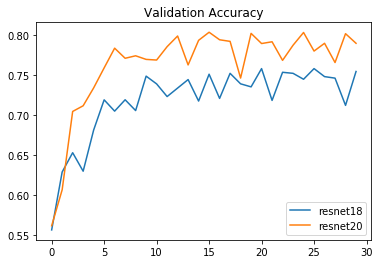

In [28]:
for net_name in ['resnet18', 'resnet20']:
  plt.plot(accuracies[net_name], label=net_name)
plt.legend()
plt.title('Validation Accuracy');

### Loss

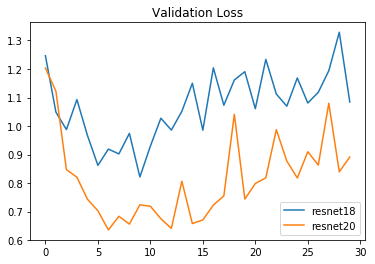

In [29]:
for net_name in ['resnet18', 'resnet20']:
  plt.plot(loss[net_name], label=net_name)
plt.legend()
plt.title('Validation Loss');

## 3. ResNet110 и ResNet110 без BatchNorm

### Accuracy

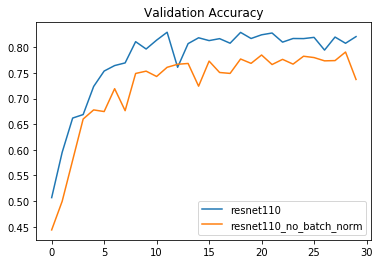

In [30]:
for net_name in ['resnet110', 'resnet110_no_batch_norm']:
  plt.plot(accuracies[net_name], label=net_name)
plt.legend()
plt.title('Validation Accuracy');

### Loss

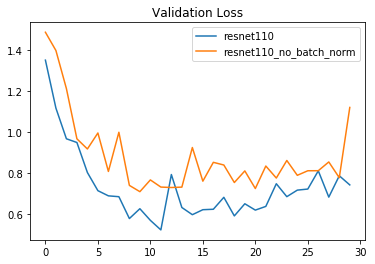

In [31]:
for net_name in ['resnet110', 'resnet110_no_batch_norm']:
  plt.plot(loss[net_name], label=net_name)
plt.legend()
plt.title('Validation Loss');

## 4. ResNet20 c  Dropout

### Accuracy

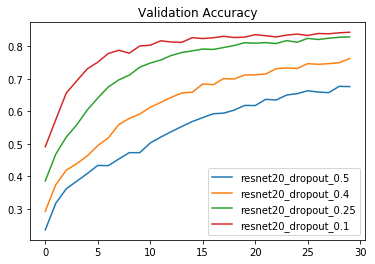

In [32]:
for dropout_p in [0.5, 0.4, 0.25, 0.1]:
  net_name = 'resnet20_dropout_{}'.format(dropout_p)
  plt.plot(accuracies[net_name], label=net_name)
plt.legend()
plt.title('Validation Accuracy');

### Loss

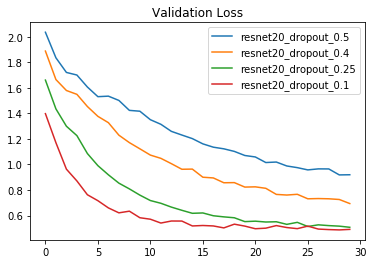

In [33]:
for dropout_p in [0.5, 0.4, 0.25, 0.1]:
  net_name = 'resnet20_dropout_{}'.format(dropout_p)
  plt.plot(loss[net_name], label=net_name)
plt.legend()
plt.title('Validation Loss');

## 5. ResNet20 c l2-регуляризацией

### Accuracy

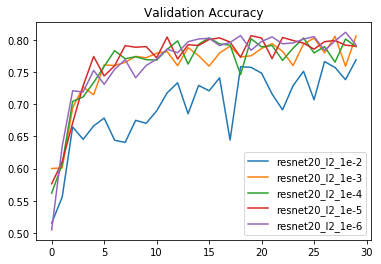

In [34]:
for wd in ['1e-2', '1e-3', '1e-4', '1e-5', '1e-6']:
  net_name = 'resnet20_l2_{}'.format(wd)
  plt.plot(accuracies[net_name], label=net_name)
plt.legend()
plt.title('Validation Accuracy');

### Loss

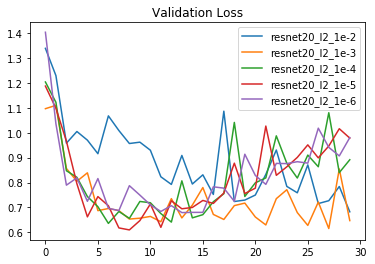

In [35]:
for wd in ['1e-2', '1e-3', '1e-4', '1e-5', '1e-6']:
  net_name = 'resnet20_l2_{}'.format(wd)
  plt.plot(loss[net_name], label=net_name)
plt.legend()
plt.title('Validation Loss');